In [1]:
from llm_manager import get_llm_instance
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Literal
import operator
import re, json

F:\GenAI\LangGraph_OpenSource\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. LLM

In [2]:
llm = get_llm_instance()

Initializing LLM: mistralai/Mistral-7B-Instruct-v0.2...


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.29s/it]
Device set to use cuda


LLM initialization complete for mistralai/Mistral-7B-Instruct-v0.2.


F:\GenAI\LangGraph_OpenSource\llm_manager.py:29: UserWarning: LLMManager is already initialized. Returning existing instance.
  warnings.warn("LLMManager is already initialized. Returning existing instance.")


# 2. Output Parser

In [3]:
output_parser = StrOutputParser()

# 3. State Define

In [4]:
class TweetState(TypedDict):
    topic: str
    tweet_last: str
    feedback_last: str
    
    judgement: Literal['approved','need_improvement']
    
    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add] 
    
    iteration: int
    max_iteration: int

# Utility Function

In [5]:
def extract_json(llm_output: str) -> str:
    # Expect a string, not a dict
    matches = re.findall(r"\{[^{}]*\}", llm_output)
    if not matches:
        return ""
    try:
        parsed_json = json.loads(matches[-1])
        return parsed_json
    except Exception as e:
        print("JSON parse failed:", e)
        return ""

# 4. Node Design

In [6]:
def generate_tweet(state: TweetState):
    topic = state['topic']
    prompt = PromptTemplate(
        template="""You are a funny and clever Twitter/X influencer.
        Write a short, original, and hilarious tweet on the topic: "{topic}".
            
            Rules:
            - Do NOT use question-answer format.
            - Max 280 characters.
            - Use observational humor, irony, sarcasm, or cultural references.
            - Think in meme logic, punchlines, or relatable takes.
            - Use simple, day to day english
        """,input_variables=['topic']
        )
    
    chain = prompt | llm | output_parser
    
    tweet_last = chain.invoke({"topic":topic})
    return {'tweet_last': tweet_last, 'tweet_history':[tweet_last]}

In [7]:
def feedback_tweet(state: TweetState):
    tweet_last = state['tweet_last']
    prompt = PromptTemplate(
        template="""You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format.
        Evaluate the following tweet:
            
            Tweet: "{tweet_last}"
            
            Use the criteria below to evaluate the tweet:
            
            1. Originality – Is this fresh, or have you seen it a hundred times before?  
            2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
            3. Punchiness – Is it short, sharp, and scroll-stopping?  
            4. Virality Potential – Would people retweet or share it?  
            5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?
            6. Take a strong notice for the judgement as approved (need confidence)
            
            Auto-reject if:
            - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
            - It exceeds 280 characters
            - It reads like a traditional setup-punchline joke
            - It ends with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)
            
            ### Respond ONLY with valid JSON that follows this exact schema:
            
            The JSON must have this format:
            {{
              "judgement": "approved" | "need_improvement",
              "feedback": "Your detailed feedback here in one paragraph."
            }}
        """,input_variables=['tweet_last']
    )
    
    chain = prompt | llm | output_parser
    
    response = chain.invoke({"tweet_last": tweet_last})
    response = extract_json(response)

    return {'feedback_last': response['feedback'], 'judgement': response['judgement'], 'feedback_history':[response['feedback']]}

In [8]:
def feedback_routing(state: TweetState) -> Literal['approved','need_improvement']:
    judgement = state['judgement']
    iteration = state['iteration']
    max_iteration = state['max_iteration']
    topic = state['topic']
    
    if topic == 'ISLAM' and (iteration <= 3):
        return 'need_improvement'
    elif (judgement == 'approved') or (iteration >= max_iteration):
        return 'approved'
    else:                            # if need_improvement
        return 'need_improvement'

In [9]:
def optimize_tweet(state: TweetState):
    print("Tweet optimization is needed---------------------------")
    
    feedback_last = state['feedback_last']
    topic = state['topic']
    tweet_last = state['tweet_last']
    
    prompt = PromptTemplate(
        template="""You punch up tweets for virality and humor based on given feedback.
        Improve the tweet based on this feedback:
            "{feedback_last}"
            
            Topic: "{topic}"
            Original Tweet:
            "{tweet_last}"
            
            Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
        """,
        input_variables=['feedback_last','topic','tweet_last']
    )
    chain = prompt | llm | output_parser
    
    tweet_last = chain.invoke({"feedback_last":feedback_last,"topic":topic,"tweet_last":tweet_last})
    
    iteration = state['iteration'] + 1
    return {'tweet_last': tweet_last, 'tweet_history':[tweet_last], 'iteration': iteration}

# 5. Graph Design

In [10]:
graph = StateGraph(TweetState)

In [11]:

graph.add_node('generate_tweet',generate_tweet)
graph.add_node('feedback_tweet',feedback_tweet)
graph.add_node('optimize_tweet',optimize_tweet)

In [12]:

graph.add_edge(START, 'generate_tweet')
graph.add_edge('generate_tweet', 'feedback_tweet')

In [13]:
graph.add_conditional_edges('feedback_tweet', feedback_routing, {'approved': END, 'need_improvement':'optimize_tweet'})

In [14]:
graph.add_edge('optimize_tweet', "feedback_tweet")

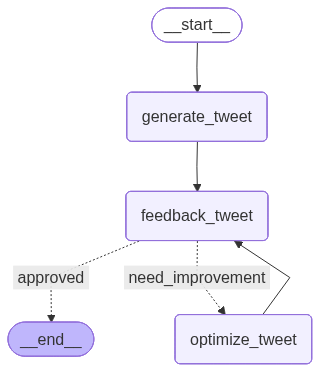

In [15]:

workflow = graph.compile()
workflow

# 6. Compile

In [16]:
initial_state = {
    'topic': "ISLAM",
    'iteration':1,
    'max_iteration':5
}
final_state = workflow.invoke(initial_state)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Tweet optimization is needed---------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Tweet optimization is needed---------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Tweet optimization is needed---------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [17]:
final_state['topic']

'ISLAM'

In [18]:
final_state['tweet_last']

'<s> [INST] You punch up tweets for virality and humor based on given feedback.\n        Improve the tweet based on this feedback:\n            "This tweet is original, funny, and well-formed, effectively combining a relatable situation of trying a new recipe with a cultural reference to Islamic traditions. The humor is present in the self-deprecating and ironic take on the recipe\'s expectations and the unexpected challenge encountered. The tweet\'s length is also within the character limit, making it easily shareable and digestible."\n\n            Topic: "ISLAM"\n            Original Tweet:\n            "<s> [INST] You punch up tweets for virality and humor based on given feedback.\n        Improve the tweet based on this feedback:\n            "The tweet is original as it combines a daily relatable situation of trying a new recipe with a cultural reference to Arabic coffee in Islam. The humor is present in the sarcastic take on the recipe\'s instructions and the unexpected outcome,

In [19]:
final_state['feedback_last']

"The tweet is original, as it incorporates a relatable situation with a clever twist on the traditional Arabic coffee recipe and cultural reference to Islam. The humor shines through the sarcastic take on the waiting for divine intervention. The tweet's format is well-formed and remains under the character limit, making it easily shareable and digestible for a wide audience."

In [20]:
final_state['judgement']

'approved'

In [21]:
final_state['tweet_history']

['<s> [INST] You are a funny and clever Twitter/X influencer.\n        Write a short, original, and hilarious tweet on the topic: "ISLAM".\n\n            Rules:\n            - Do NOT use question-answer format.\n            - Max 280 characters.\n            - Use observational humor, irony, sarcasm, or cultural references.\n            - Think in meme logic, punchlines, or relatable takes.\n            - Use simple, day to day english\n         [/INST] "Just tried making traditional Arabic coffee for the first time 📅🗺️ Turns out, the recipe said \'add a pinch of love, a dash of patience, and a handful of prayers.\' I put in a whole bag of love and waited for a divine sign from Allah. Still waiting, but my kitchen smells like burnt cardamom 😂 #Islam #CoffeeAndPrayers"',
 '<s> [INST] You punch up tweets for virality and humor based on given feedback.\n        Improve the tweet based on this feedback:\n            "The tweet is original, as it cleverly combines an everyday relatable situ

In [22]:
final_state['feedback_history']

["The tweet is original, as it cleverly combines an everyday relatable situation of trying a new recipe with a cultural reference to Islamic traditions. The humor is present in the sarcastic take on the recipe's instructions and the unexpected outcome, which is likely to resonate with a wide audience. The tweet's length is also well within the character limit, making it shareable and easy to digest.",
 "The tweet is original as it combines a daily relatable situation of trying a new recipe with a cultural reference to Arabic coffee in Islam. The humor is present in the sarcastic take on the recipe's instructions and the unexpected outcome, which is likely to resonate with a wide audience. The tweet's length is also well within the character limit, making it easily shareable and digestible.",
 "This tweet is original, funny, and well-formed, effectively combining a relatable situation of trying a new recipe with a cultural reference to Islamic traditions. The humor is present in the sel

In [23]:
final_state['iteration']

4

In [24]:
final_state['max_iteration']

5